## Background

In this notebook I'll walk through an algorithm suggested by Claude to distinguish one typeface (like `display`) from another (like `serif`) in which we calculate the ratio of the perimeter to area of each letter. This algorithm is relatively simple (utilizing the power of the OpenCV library).

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my [TypefaceClassifier project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

In [8]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## Load and Binarize the Image

As usual, we'll load the image and binarize it so the text is white and the background is black.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
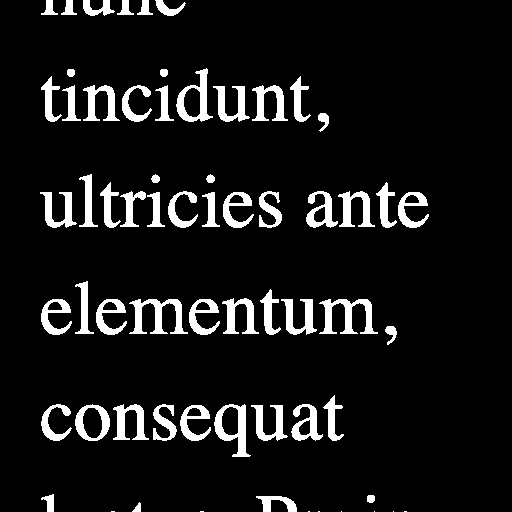

In [9]:
path = 'serif-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Calculate the Ratio of Contour Perimeter to Area

Next, we calculate the contours in the image

In [10]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

I'll visualize the contours to show what we're dealing with. As you can see---the contours are essentially the letter boundaries.

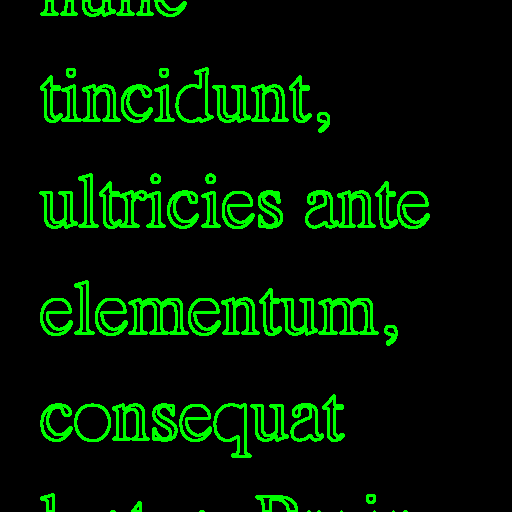

In [11]:
contour_image = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
cv2_imshow(contour_image)

We then calculate the total perimeter and total area of all contours:

In [12]:
total_perimeter = sum(cv2.arcLength(contour, True) for contour in contours)
total_area = sum(cv2.contourArea(contour) for contour in contours)

And take the ratio of the two:

In [13]:
ratio = total_perimeter / total_area if total_area > 0 else 0
ratio

0.3750295759392109

## Calculating Contour Ratio for Multiple Images

I'll wrap the above functionality (except for the contour visualization) into a function and calculate the ratio for different images of different typefaces.

In [14]:
def contour_ratio(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_perimeter = sum(cv2.arcLength(contour, True) for contour in contours)
    total_area = sum(cv2.contourArea(contour) for contour in contours)

    ratio = total_perimeter / total_area if total_area > 0 else 0

    return ratio

On average, images with serif fonts have a higher contour ratio (perimeter:area) than images with display fonts. This matches my intuition: serif fonts have more detailed elements (the serifs) which increase the perimeter of the shape for a given area.

In [19]:
szs = [8, 18, 24, 36, 76, 240, 330, 420]
ts = ['display', 'serif']
res = []

for t in ts:
    for sz in szs:
        image_path = f"{t}-{sz}px.png"
        sr = contour_ratio(image_path)
        res.append([t, sz, sr])

res = pd.DataFrame(res, columns=['typeface', 'font-size', 'contour-ratio'])
res.groupby('typeface')['contour-ratio'].agg(['mean', 'median'])

,mean,median
typeface,,
display,0.577296,0.345773
serif,0.781032,0.548321


For all font sizes (except 72px) this trend is evident: the serif texts have a larger perimeter:area ratio than the sans serif `display` texts.

In [20]:
res.sort_values(by='font-size')

,typeface,font-size,contour-ratio
0,display,8,2.050135
8,serif,8,2.218431
1,display,18,0.992742
9,serif,18,1.530445
2,display,24,0.730834
10,serif,24,1.106150
3,display,36,0.459297
11,serif,36,0.721613
4,display,76,0.232250
12,serif,76,0.375030


## Final Thoughts

Among the algorithms I've tested, this one demonstrates the highest consistency in differentiating typefaces, regardless of font size, making it a great candidate for a non-ML typeface classification baseline.

I'm also a huge fan of simplicity and this is one of the simplest algorithms for this task that I have implemented. A win-win!

I hope you enjoyed this blog post. Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).